(1, 0.0, False, {'prob': 0.3333333333333333})
Average reward with alpha=0.5, gamma=0.95, epsilon=1.0: 0.266
Final Q-table with alpha=0.5, gamma=0.95, epsilon=1.0:
 [[0.22932384 0.10083721 0.10328055 0.13622133]
 [0.01269071 0.05294783 0.02202229 0.15615323]
 [0.03170875 0.12414031 0.06358228 0.03126253]
 [0.02458295 0.05133449 0.01601655 0.08360728]
 [0.34682062 0.10111006 0.04595797 0.05700287]
 [0.         0.         0.         0.        ]
 [0.00883567 0.02587999 0.23990195 0.00375247]
 [0.         0.         0.         0.        ]
 [0.150228   0.06167107 0.13258917 0.40187932]
 [0.24043033 0.49311575 0.07928502 0.04916282]
 [0.59003029 0.15711064 0.04796942 0.01864821]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.10690629 0.14501292 0.49079914 0.04887385]
 [0.35435195 0.80533881 0.3441339  0.41291857]
 [0.         0.         0.         0.        ]]

Average reward with alpha=0.5, gamma=0.95, epsilon=0.5: 0.3288
Final Q-table with 

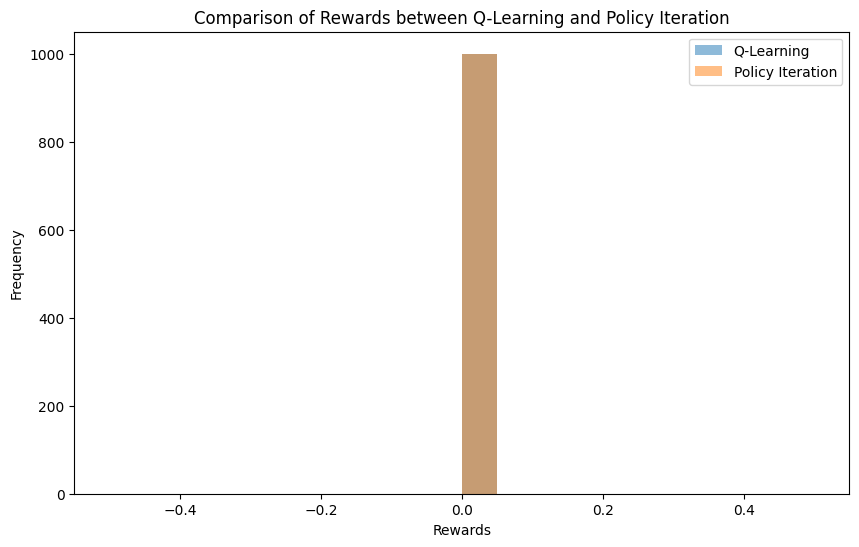

Average reward with Q-learning: 0.0
Average reward with policy iteration: 0.0


In [ ]:
# Import necessary libraries
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

# Initialize the "FrozenLake" environment
env = gym.make("FrozenLake-v1")
env.reset()
print(env.step(env.action_space.sample()))

# Set the number of actions and states
num_actions = env.action_space.n
num_states = env.observation_space.n

# Initialize Q-table with zeros
Q = np.zeros([num_states, num_actions])

# Define hyperparameters
alphas = [0.5, 0.8, 0.1]
gammas = [0.95, 0.8, 0.6]
epsilons = [1.0, 0.5, 0.1]
# epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.999
total_episodes = 5000

# Initialize lists to store results
average_rewards = []
final_Q_tables = []

# Loop over all combinations of hyperparameters
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            # Initialize Q-table with zeros
            Q = np.zeros([num_states, num_actions])

            # List to store rewards
            rewards = []

            # Start Q-learning process
            for episode in range(total_episodes):
                # Reset the environment
                state = env.reset()
                done = False
                total_rewards = 0

                for step in range(100):  # Limit each episode to a maximum of 100 steps
                    # Choose action: random for exploration and max Q for exploitation
                    if random.uniform(0, 1) < epsilon:
                        action = env.action_space.sample()  # Explore action space
                    else:
                        action = np.argmax(Q[state, :])  # Exploit learned values

                    # Perform the action and get the reward
                    new_state, reward, done, info = env.step(action)

                    # Update Q-table for Q(s,a)
                    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

                    total_rewards += reward  # Add reward to total rewards

                    state = new_state  # Update the state

                    # If done, then finish the episode
                    if done:
                        break

                # Decay epsilon to reduce exploration as time progresses
                epsilon = max(epsilon_min, epsilon * epsilon_decay)

                # Store total reward of each episode
                rewards.append(total_rewards)

            # Store average reward and final Q-table for each set of hyperparameters
            average_rewards.append(sum(rewards) / total_episodes)
            final_Q_tables.append(Q)

# Display the results
for i in range(len(average_rewards)):
    print(f"Average reward with alpha={alphas[i//9]}, gamma={gammas[(i//3)%3]}, epsilon={epsilons[i%3]}: {average_rewards[i]}")
    print(f"Final Q-table with alpha={alphas[i//9]}, gamma={gammas[(i//3)%3]}, epsilon={epsilons[i%3]}:\n {final_Q_tables[i]}\n")

from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

def policy_evaluation(policy, env, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    V = np.zeros(env.observation_space.n)
    for i in range(int(max_iterations)):
        delta = 0
        for state in range(env.observation_space.n):
            v = 0
            for action, action_prob in enumerate(policy[state]):
                for prob, next_state, reward, done in env.P[state][action]:
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            delta = max(delta, np.abs(V[state] - v))
            V[state] = v
        if delta < theta:
            break
    return V

def policy_improvement(env, policy_eval_fn=policy_evaluation, discount_factor=1.0):
    def one_step_lookahead(state, V):
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
    while True:
        V = policy_eval_fn(policy, env, discount_factor)
        policy_stable = True
        for state in range(env.observation_space.n):
            chosen_a = np.argmax(policy[state])
            action_values = one_step_lookahead(state, V)
            best_a = np.argmax(action_values)
            if chosen_a != best_a:
                policy_stable = False
            policy[state] = np.eye(env.action_space.n)[best_a]
        if policy_stable:
            return policy, V
env = FrozenLakeEnv(map_name="4x4", is_slippery=True)
policy, v = policy_improvement(env)

print("Policy Probability Distribution:")
print(policy)
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.desc.shape))

def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.argmax(policy[state])
        # print(f"Action: {action}")
        result = env.step(action)
        # print(f"Result: {result}")
        state, reward, done, _, _ = result  # Change this line
        total_reward += reward
    # print(total_reward)
    return total_reward


# Run the policy obtained from Q-learning
q_learning_rewards = [run_episode(env, np.argmax(Q, axis=1)) for _ in range(1000)]
average_q_learning_reward = np.mean(q_learning_rewards)

# Run the policy obtained from policy iteration
policy_iteration_rewards = [run_episode(env, np.argmax(policy, axis=1)) for _ in range(1000)]
average_policy_iteration_reward = np.mean(policy_iteration_rewards)

# Plot the rewards
plt.figure(figsize=(10,6))
plt.hist(q_learning_rewards, alpha=0.5, label='Q-Learning', bins=20)
plt.hist(policy_iteration_rewards, alpha=0.5, label='Policy Iteration', bins=20)
plt.xlabel('Rewards')
plt.ylabel('Frequency')
plt.title('Comparison of Rewards between Q-Learning and Policy Iteration')
plt.legend(loc='upper right')
plt.show()

print(f"Average reward with Q-learning: {average_q_learning_reward}")
print(f"Average reward with policy iteration: {average_policy_iteration_reward}")# Plot the rewards



In [5]:
!pip install gym[atari]
!pip install gym --upgrade



import gym
import numpy as np
import tensorflow as tf
import random
from gym.wrappers import AtariPreprocessing

# env_names = gym.envs.registry.env_specs.keys()
# print(env_names)
# print(gym.envs.registry.all())


class DQN:
    def __init__(self, state_shape, n_actions, lr=0.00025, gamma=0.95, epsilon_start=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_size=10000, batch_size=32):
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = []
        self.memory_size = memory_size
        self.batch_size = batch_size

        self.model = self._build_network(state_shape, lr)
        self.target_model = self._build_network(state_shape, lr)
        self.sync_target()

    def _build_network(self, state_shape, lr):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=state_shape),
            tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(self.n_actions)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mean_squared_error')
        return model

    def sync_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        q_values = self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)

    # def train(self):
    #     if len(self.memory) < self.batch_size:
    #         return
    #     minibatch = random.sample(self.memory, self.batch_size)
    #     states, targets = [], []
    #     for state, action, reward, next_state, done in minibatch:
    #         target = reward
    #         if not done:
    #             q_values_next_state = self.target_model.predict(np.expand_dims(next_state, axis=0))
    #             target = reward + self.gamma * np.max(q_values_next_state[0])
    #         print("State Shape:", state.shape)
    #         print("State Type:", type(state))

    #         final_target = self.model.predict(np.expand_dims(state, axis=0))
    #         final_target[0][action] = target
    #         states.append(state)
    #         targets.append(final_target[0])
    #     self.model.train_on_batch(np.array(states), np.array(targets))

    #     if self.epsilon > self.epsilon_min:
    #         self.epsilon *= self.epsilon_decay

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = np.array(states)
        next_states = np.array(next_states)

        actions = np.asarray(actions)

        q_values_next_state = self.target_model.predict(next_states)
        targets = rewards + self.gamma * np.max(q_values_next_state, axis=1) * (1 - dones)
        targets = np.expand_dims(targets, axis=1)

        # Change the type of the action variable to a numpy array
        action = actions[:, 0]

        final_target = self.model.predict(np.expand_dims(states, axis=0))
        final_target[0][action] = targets[0]
        self.model.train_on_batch(states, targets)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def sync_target(self):
        self.target_model.set_weights(self.model.get_weights())


if __name__ == '__main__':
    # env = AtariPreprocessing(gym.make("BreakoutNoFrameskip-v4"))
    env = gym.make('Breakout-v4')

    dqn = DQN(state_shape=(210, 160, 3), n_actions=env.action_space.n)

    EPISODES = 500
    SYNC_TARGET_STEPS = 1000
    steps = 0

    for e in range(EPISODES):
        state = env.reset()
        done = False
        while not done:
            action = dqn.act(state)
            # output = env.step(action)
            # print(output)

            next_state, reward, done, _, info = env.step(action)

            dqn.remember(state, action, reward, next_state, done)
            state = next_state
            print("State shape:",np.shape(state))
            print(type(state))
            if isinstance(state, list):
                for s in state:
                    print(np.shape(s))
                # for s in state:
                #     prediction = self.model.predict(np.expand_dims(s, axis=0))


            dqn.train()
            steps += 1
            if steps % SYNC_TARGET_STEPS == 0:
                dqn.sync_target()


ModuleNotFoundError: ignored

In [ ]:
%pip install keras

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
import gym

# Constants
GAMMA = 0.99
LR_ACTOR = 0.0003
LR_CRITIC = 0.001
CLIPPING_LOSS_RATIO = 0.2
EPOCHS = 10
BATCH_SIZE = 32

class PPO:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions

        self.actor = self.create_actor()
        self.critic = self.create_critic()
        self.old_actor = self.create_actor()
        self.old_actor.set_weights(self.actor.get_weights())

    def create_actor(self):
        states = Input(shape=self.state_dim)
        x = Dense(64, activation='relu')(states)
        x = Dense(64, activation='relu')(x)
        probs = Dense(self.n_actions, activation='softmax')(x)
        model = keras.models.Model(inputs=states, outputs=probs)
        return model

    def create_critic(self):
        states = Input(shape=self.state_dim)
        x = Dense(64, activation='relu')(states)
        x = Dense(64, activation='relu')(x)
        values = Dense(1)(x)
        model = keras.models.Model(inputs=states, outputs=values)
        return model

    # def get_action(self, state):
    #     probabilities = self.actor.predict(np.expand_dims(state, axis=0))
    #     action = np.random.choice(self.n_actions, p=probabilities[0])
    #     return action

    def get_action(self, state):
        state = np.array(state).flatten()  # Flatten the state
        probabilities = self.actor.predict(np.expand_dims(state, axis=0))
        action = np.random.choice(self.n_actions, p=probabilities[0])
        return action


    def train(self, states, actions, rewards, next_states, dones):
        actor_optimizer = keras.optimizers.Adam(learning_rate=LR_ACTOR)
        critic_optimizer = keras.optimizers.Adam(learning_rate=LR_CRITIC)

        old_probs = self.old_actor.predict_on_batch(states)
        values = self.critic.predict_on_batch(states)
        next_values = self.critic.predict_on_batch(next_states)
        targets = rewards + GAMMA * next_values * (1-dones)
        advantages = targets - values

        for _ in range(EPOCHS):
            for idx in range(0, len(states), BATCH_SIZE):
                batch_states = states[idx:idx+BATCH_SIZE]
                batch_actions = actions[idx:idx+BATCH_SIZE]
                batch_advantages = advantages[idx:idx+BATCH_SIZE]
                batch_old_probs = old_probs[idx:idx+BATCH_SIZE]

                with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
                    probs = self.actor(batch_states)
                    batch_action_probs = probs[np.arange(len(batch_states)), batch_actions]
                    batch_old_action_probs = batch_old_probs[np.arange(len(batch_states)), batch_actions]
                    ratios = batch_action_probs / (batch_old_action_probs + 1e-10)

                    # Clipping Loss
                    surrogate1 = ratios * batch_advantages
                    surrogate2 = tf.clip_by_value(ratios, 1 - CLIPPING_LOSS_RATIO, 1 + CLIPPING_LOSS_RATIO) * batch_advantages
                    actor_loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))

                    current_values = self.critic(batch_states)
                    critic_loss = tf.reduce_mean(tf.square(current_values - targets))

                actor_grads = tape1.gradient(actor_loss, self.actor.trainable_variables)
                critic_grads = tape2.gradient(critic_loss, self.critic.trainable_variables)

                actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
                critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        self.old_actor.set_weights(self.actor.get_weights())

env = gym.make("Pong-v0")
state_dim = env.observation_space.shape
n_actions = env.action_space.n

ppo = PPO(state_dim, n_actions)

for _ in range(1000): # Number of episodes
    state = env.reset()
    episode_states, episode_actions, episode_rewards, episode_next_states, episode_dones = [], [], [], [], []

    while True:
        action = ppo.get_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)
        episode_next_states.append(next_state)
        episode_dones.append(done)

        if done:
            ppo.train(np.array(episode_states), np.array(episode_actions), np.array(episode_rewards), np.array(episode_next_states), np.array(episode_dones))
            break
        state = next_state
